# Poisson model
Create Poisson model for goals scored for each team, see https://www.pinnacle.com/en/betting-articles/soccer/how-to-calculate-poisson-distribution


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline 

data_path = "./data/" 
dic = {}

cols = ["Div","Date","HomeTeam","AwayTeam",
       "FTHG","FTAG","FTR","HTHG","HTAG","HTR"
]

matches = pd.DataFrame(None,columns=cols) # Empty dataframe we'll add the data to

for f in [x for x in os.listdir(data_path)]: #if "prem" in x]:
    print(f)
    results_df = pd.read_csv(data_path+f,usecols=cols,parse_dates=True)
    results_df = results_df.dropna(how="all") # kill empty last rows, below tests this isn't deleting any matches
    
    if f.split("_")[0] == "prem": # premiership, 20 teams play each other twice, 20*19 total matches
        assert len(results_df) == 20*19
    else:
        assert len(results_df) == 24*23 # lower leagues, 24 teams play 2x, 24*23 total
    
    results_df["Season"] = (f.split("_")[-1].split(".")[0])
    results_df["Season"] = results_df["Season"]
    
    matches = pd.concat([results_df,matches])

# reorder data by date
matches["Date"] = pd.to_datetime(matches["Date"],dayfirst=True)
matches = matches.sort_values(by="Date")
matches = matches.reset_index(drop=True)
print("==="*3)
print(matches.head())

prem_0910.csv
prem_1314.csv
league_1_0910.csv
champ_0910.csv
league_2_1213.csv
league_2_1112.csv
champ_1314.csv
prem_1617.csv
league_1_1112.csv
league_1_1213.csv
league_2_1011.csv
league_2_1516.csv
league_2_1415.csv
league_1_1011.csv
league_1_1415.csv
league_2_0910.csv
prem_1011.csv
prem_1213.csv
league_2_1617.csv
champ_1011.csv
champ_1213.csv
champ_1516.csv
league_1_1617.csv
prem_1112.csv
champ_1415.csv
champ_1112.csv
champ_1617.csv
league_1_1314.csv
league_1_1516.csv
league_2_1314.csv
prem_1415.csv
prem_1516.csv
           AwayTeam       Date Div FTAG FTHG FTR HTAG HTHG HTR       HomeTeam  \
0  Sheffield United 2009-08-07  E1    0    0   D    0    0   D  Middlesbrough   
1         Peterboro 2009-08-08  E1    1    2   H    0    1   H          Derby   
2           Swansea 2009-08-08  E1    1    2   H    1    0   A      Leicester   
3      Bristol City 2009-08-08  E1    2    2   D    0    0   D        Preston   
4         Blackpool 2009-08-08  E1    1    1   D    1    0   A            Q

# Train model

In [40]:
### PARAMETERS
train_season = "1516"
predict_season = "1617"
#####

# find starting season from train_start_date
train_season_matches = matches.loc[matches["Season"] == train_season]

# Get 2016-2017 premiership matches
predict_season_matches = matches.loc[matches["Season"] == predict_season]# 2016-2017 season

## Initialise attack/def for teams
team_stats = {}
for team in matches["HomeTeam"].unique():
    if team not in list(team_stats.keys()):
        team_stats[team] = {"home_att" : 1, "home_def" : 1, "away_att" : 1, "away_def" : 1}

### TRAINING
# 1 - Find total goals scored home/away for each league in training set
league_goals = {}
for div in train_season_matches["Div"].unique():
    div_matches = train_season_matches.loc[train_season_matches["Div"] == div]
    league_goals[div] = {}
    league_goals[div]["Home goals scored"] = div_matches["FTHG"].sum()/len(div_matches)
    league_goals[div]["Away goals scored"] = div_matches["FTAG"].sum()/len(div_matches)
    # Conceded is simply the above swapped
    league_goals[div]["Home goals conceded"] = league_goals[div]["Away goals scored"]
    league_goals[div]["Away goals conceded"] = league_goals[div]["Home goals scored"]

    
# Run through all teams and their goals in training season, update attack/defence ratings
for team in pd.concat([train_season_matches,predict_season_matches])["HomeTeam"].unique():
    
    home_matches = train_season_matches.loc[train_season_matches["HomeTeam"] == team]
    away_matches = train_season_matches.loc[train_season_matches["AwayTeam"] == team]
    
    # Team is present in training set, if not then they must be promoted so ignore
    # this leaves att/def as default vals of 1.0, 1.0    
    if len(set(home_matches["Div"])) == 1:
        starting_division = home_matches["Div"].iloc[0]
        total_home_goals = home_matches["FTHG"].sum()/len(home_matches)
        team_stats[team]["home_att"] = total_home_goals/league_goals[starting_division]["Home goals scored"]
        
        total_away_goals = away_matches["FTAG"].sum()/len(away_matches)
        team_stats[team]["away_att"] = total_away_goals/league_goals[starting_division]["Away goals scored"]

        total_home_conceded = home_matches["FTAG"].sum()/len(home_matches)
        team_stats[team]["home_def"] = total_home_conceded/league_goals[starting_division]["Home goals conceded"]
        
        total_away_conceded = away_matches["FTHG"].sum()/len(away_matches)
        team_stats[team]["away_def"] = total_away_conceded/league_goals[starting_division]["Away goals conceded"]
        
        #print(team,team_stats[team])

# Testing

In [73]:
import math

def poisson(mu,k):
    return np.exp(-mu) * (mu**k) / math.factorial(k)


for ix, match in predict_season_matches.iterrows():
    home_team = match["HomeTeam"]
    away_team = match["AwayTeam"]
    div = match["Div"]
    
    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]
    league_stats = league_goals[div]

    # Mean home goals = Home Att * Away Def * Avg goals for division
    expected_home_goals = home_stats["home_att"]*away_stats["away_def"]*league_stats["Home goals scored"]
    expected_away_goals = home_stats["home_def"]*away_stats["away_att"]*league_stats["Away goals scored"]    
    
    max_goals = 5
#     probability_matrix = np.zeros(shape=(max_goals,max_goals))
    
    home_goals_dist = np.array([poisson(expected_home_goals,k) for k in range(max_goals+1)])
    away_goals_dist = np.array([poisson(expected_away_goals,k) for k in range(max_goals+1)])

    prob_matrix = np.outer(home_goals_dist,away_goals_dist) # HOME GOALS = ROWS
    
    home_goals, away_goals = list(np.where(prob_matrix == prob_matrix.max()))
    
    if home_team == "Tottenham" and away_team == "Everton": # check against pinnacle.com poisson example
        print(pd.DataFrame(prob_matrix))
        print(home_goals,away_goals)
        #         print(expected_home_goals,expected_away_goals) # yep fine
#         for k in range(5):
#             print(poisson(expected_home_goals,k)) # also fine
#             print(poisson(expected_away_goals,k)) # FINE

          0         1         2         3         4         5
0  0.086291  0.071242  0.029408  0.008093  0.001670  0.000276
1  0.140175  0.115727  0.047772  0.013147  0.002713  0.000448
2  0.113852  0.093995  0.038801  0.010678  0.002204  0.000364
3  0.061648  0.050896  0.021010  0.005782  0.001193  0.000197
4  0.025036  0.020669  0.008532  0.002348  0.000485  0.000080
5  0.008134  0.006715  0.002772  0.000763  0.000157  0.000026
[1] [0]


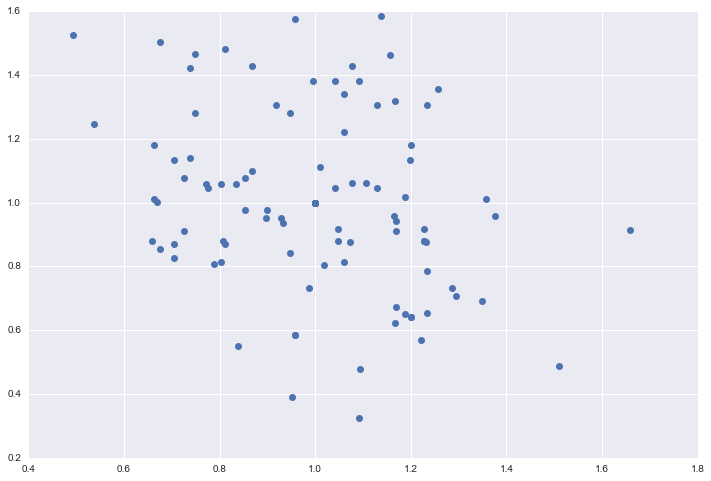

In [39]:
df = pd.DataFrame(team_stats).T
plt.figure(figsize=(12,8))
plt.plot(df["home_att"],df["home_def"],'o')